# 08 - Cross Validation, Grid Search, Decision Trees

**Note that this notebook was developed for an in-class exercise, where assistance and help is given in the classroom. We therefore provide most of the solutions, and on the other side, some parts might not be self-explanatory. Please check the documentation of scikit-learn in any case and check online resources to get further information, if the material we provided are not sufficient to understand everything. We hope you still get a lot out of this notebook in any case.**

**This notebook also has some repetitions from previous notebooks using the census dataset. You can try to solve the given tasks yourself, or use the accompanying pdf-version to follow the solutions. Working through the notebook without help is, of course, more effective for practicing and learning the content.**

A machine learning project includes the following stages:
* data collection
* exploratory data analysis - computing basic statistics, correlations, and visualizations in order to get insights into the data
* data preparation:
    * dealing with missing data
    * transforming categorical features into numerical features: one-hot encoding
    * data transformation - e.g. logarithmic transformations for features with skewed distributions
    * training test splitting 
    * data scaling - all numerical features have similar order of magnitude    
* model selection and training
* model evaluation
* model/hyperparameters fine-tuning

In the framework of this exercise, you will practice:
- more on model evaluation: ROC curve,
- training a new classifier: Decision Trees
- cross validation
- hyperparameter selection with grid search

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Load Data

Import necessary Python libraries for solving this exercise: `numpy, pandas, sklearn, sklearn, matplotlib`

In [42]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

Load the *census.csv* dataset consisting of income data from the census, classifying adults into those earning above ``$50k`` per year vs. those earning below. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [43]:
from pathlib import Path
import os

data_dir = str(Path.home()) + r'/coursematerial/GIS/GeoDataScience'

filepath = os.path.join(data_dir, r'census.csv')

print(filepath)

/home/jovyan/coursematerial/GIS/GeoDataScience/census.csv


In [44]:
census = pd.read_csv(filepath)
census.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Data Exploration

A short investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'` HINT: You might want to use *df.shape* or pandas method *.value_counts()*
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [45]:
data = census
data.shape

(45222, 14)

In [46]:
data['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [47]:
n_records = data.shape[0]
n_greater_50k = np.sum(data['income']== '>50K')
n_at_most_50k = np.sum(data['income']== '<=50K')
greater_percent = n_greater_50k *100/n_records

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Feature set exploration:**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education_level**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **gender**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinidad&Tobago, Peru, Hong, Holland-Netherlands.


Experiment with visualizing the data. Can you find out which features influence the income the most?

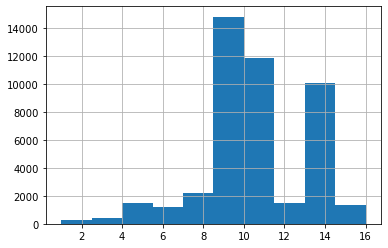

In [48]:
data['education-num'].hist();

## Data Preparation

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. This is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with. However, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

Separate the target variable from the features.
- Store the column  `'income'` in a variable `'income_raw'`
- Store the features in a variable `'features_raw'`

In [49]:
income_raw = data['income']
feature_raw = data.drop('income',axis = 1)
feature_raw[:4]

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States


**Transforming Skewed Continuous Features**

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Plot a histogram of these two features. Note the range of the values and how they are distributed.

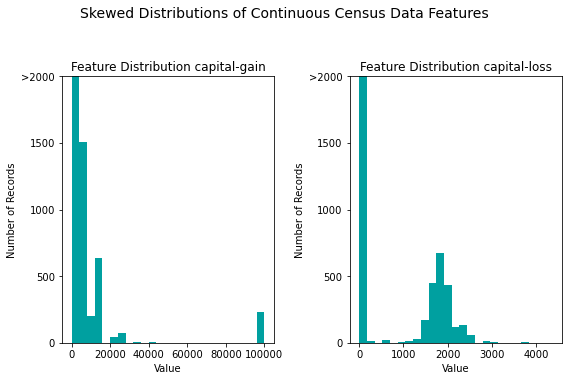

In [50]:
# Visualize skewed continuous features of original data


fig = plt.figure(figsize = (8,5)); # Create figure
 # Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1) # 
    ax.hist(data[feature], bins = 25, color = '#00A0A0')
    ax.set_title("Feature Distribution {}".format(feature), fontsize = 12)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 14, y = 1.05)
fig.tight_layout()


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a **logarithmic transformation** on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly **reduces the range of values caused by extreme values**.

Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

In [51]:
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = feature_raw)
features_log_transformed[skewed] = feature_raw[skewed].apply(lambda x: np.log(x+1))



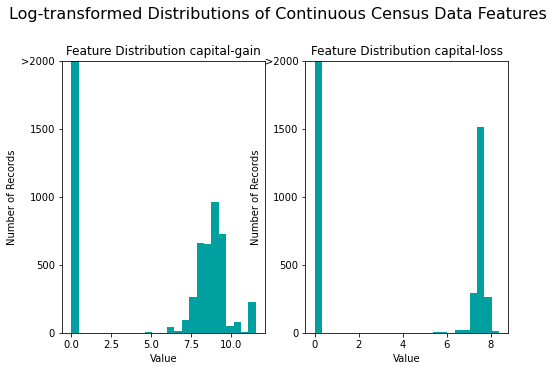

In [52]:
# Visualize the new log distributions

fig = plt.figure(figsize = (8,5)); # Create figure
 # Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1) # 
    ax.hist(features_log_transformed[feature], bins = 25, color = '#00A0A0')
    ax.set_title("Feature Distribution {}".format(feature), fontsize = 12)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])
    fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

**Normalizing Numerical Features**

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of *scaling on numerical features*. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization *ensures that each feature is treated equally* when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as the example given below shows.

To normalize each numerical feature we will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
scaler = MinMaxScaler() # default=(0, 1)
# store the names of the numerical features in a list
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']
features_log_minmax_transform = features_log_transformed
# apply scaling on numerical features by using the 'fit-transform' method of the scalar object
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])
# Show an example of a record with scaling applied
features_log_minmax_transform.head(n=3)




,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States


**Encoding categorical variables**

From the table in above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [63]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)
# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
#print(encoded)
print("{} total features after one-hot encoding.".format(len(encoded)))


103 total features after one-hot encoding.


**Shuffle and Split Data**

Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [66]:
# Import train_test_split
from sklearn.model_selection import train_test_split
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income,test_size = 0.2)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))



Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluate Model Performance

**Metrics and the Naive Predictor**

It might seem that using **accuracy** as a metric for evaluating a particular model's performance would be appropriate.

In this exercise, we are particularly interested in predicting who makes more than \$50,000 accurately.

Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-1 score** as a metric that considers both precision and recall:

$$ F_{1} = 2 \cdot \frac{precision \cdot recall}{precision  + recall} $$

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, would identify no one as earning more. 

**Note: Recap of accuracy, precision, recall**

**Accuracy** measures how often the classifier makes the correct prediction. It is the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion, e.g., of messages we classified as spam, actually were spam.
It is a ratio of true positives (words classified as spam, and which are actually spam) to all positives (all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives (words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example, if we had a 100 text messages and only 2 were spam and the rest (98) weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

**Naive Predictor Performance**

* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F1-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT:** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision (True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

**Calculate accuracy, precision, recall, and f1-score yourself.**

In [ ]:
TP = np.sum(income)
FP = income.count() - TP
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall yourself
accuracy = 0.0 # <- your code here
recall = 0.0 # <- your code here
precision = 0.0 # <- your code here

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = 0.0 # <- your code here
# Print the results
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))


## Training and Predicting Pipeline

In the code cell below, you will need to implement the following:
 - Import `LogisticRegression` and  [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).
 - Import confusion_matrix and classification_report from sklearn.metrics.
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Instantiate a logistic regression object (learner) 
   - be aware about the C parameter - regularization stength - experiment with different values for this parameter (check also the part about cross validation further below)
 - Fit the learner to the training data
 - Perform predictions on the test data `X_test`. 
 - Calculate the accuracy score for both the training subset and testing set.
 - Compute and print the confusion matrix and classification report. HINT: both take as parameters (y_test, y_pred)
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter 'beta' = 2!

In [75]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))

[[6242  534]
 [ 902 1367]]


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6776
           1       0.72      0.60      0.66      2269

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.83      0.84      0.84      9045



**Plotting an ROC curve**

Classification reports and confusion matrices are methods to quantitatively evaluate model performance, while receiver operating characteristic curves (ROC) provide a way to visually evaluate models. Most classifiers in scikit-learn have a *.predict_proba()* method which returns the probability of a given sample being in a particular class. Having built a logistic regression model, you'll now evaluate its performance by plotting an ROC curve. In doing so, you'll make use of the .predict_proba() method and become familiar with its functionality.

* Import roc_curve from sklearn.metrics.
* Using the logreg classifier, which has been fit to the training data, compute the predicted probabilities of the labels of the test set X_test. Save the result as y_pred_prob.
* Use the roc_curve() function with y_test and y_pred_prob and unpack the result into the variables fpr, tpr, and thresholds.
* Plot the ROC curve with fpr on the x-axis and tpr on the y-axis.

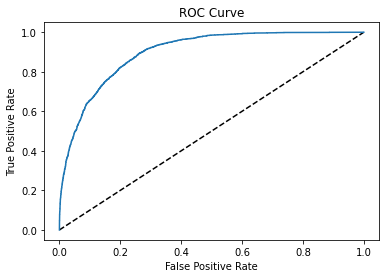

In [76]:
from sklearn.metrics import roc_curve
# Compute predicted probabilities: y_pred_prob
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds HINT: roc_curve takes as arguments (y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



## Cross Validation

Similar to the alpha parameter of lasso and ridge regularization that you saw for linear regression, logistic regression also has a regularization parameter: C, which controls the inverse of the regularization strength. 

A large C can lead to an overfit model, while a small C can lead to an underfit model. Practice with different values for C parameter and evaluate the trained models. Which is the optimal value for C?

In addition to C, logistic regression has a 'penalty' hyperparameter which specifies whether to use 'l1' or 'l2' regularization. Experiment with the different type of regularization methods!

**Cross-Validation in scikit-learn**

Cross validation is a statistical method of evaluating generalization performance
- more stable than train test split
- the data is split repeatedly (equal parts called 'folds') and multiple models are trained

*Important* - cross validation does not return a model! It cannot be applied to new data!
But: multiple models are built internally, its purpose is to evaluate how well a given algorithms (with a set of hyperparameters) will generalize when trained on a specific dataset!

* import cross_val_score from model_selection submodule
* instantiate a Logistic Regression object (estimator) with default parameters (use max_iter=1000)
* call cross_val_score by providing the estimator, features and labels as arguments

**This might take a little time!** Fortunately, you can use several parallel jobs (with the parameter n_jobs) for this purpose.

In [79]:
from sklearn.model_selection import cross_val_score
log_reg_obj = LogisticRegression(max_iter=1000)
scores = cross_val_score(log_reg_obj, X_train, y_train, n_jobs=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.84355998 0.84618574 0.83745681 0.84616448 0.83842433]


Just by looking at the output of the cross_val_score, which is the default number of folds?

In [81]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.84


The function **cross_validate()** gives more informative outcomes: Evaluation metric(s) by cross-validation and also record fit/score times.

In [84]:
from sklearn.model_selection import cross_validate
cross_validate(log_reg_obj, X_train, y_train, n_jobs=5)

{'fit_time': array([4.08654881, 4.08845162, 4.24089217, 3.99167156, 4.1746242 ]),
 'score_time': array([0.00286937, 0.00301909, 0.00298047, 0.00282764, 0.00283456]),
 'test_score': array([0.84355998, 0.84618574, 0.83745681, 0.84616448, 0.83842433])}

## Stratified K-Fold Cross-Validation and others

More control over cross-validation

* cross_validate allows us to adjust the number of folds that are used using the **cv = ** parameter
* a finer control over the splitting process is possible by providing a cross-validation **splitter** object as parameter to a **cross validation object***

**Tasks:**
* create a Kfold object by specifing the parameter *n_splits=5*)
* use the kfold object as value for the *cv =* parameters for a *cross_val_score* object along with your classifier and data

In [85]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
scores = cross_val_score(log_reg_obj, X_train, y_train, cv=kfold, n_jobs=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.84328358 0.84784411 0.83718037 0.84602626 0.83676572]


**Shuffle-split cross-validation**

This strategy allows to split *n_split* times, each split **sampling (with replacement)**
- *train_size* many points from the dataset and
- *test_size* many data points for the test set

**Tasks:**
* instantiate a ShuffleSplit object by specifying as values for the parameters: *test_size= .5, train_size= 0.5, n_splits= 10*
* use the  ShuffleSplit object as value for the *cv =* parameters for a *cross_val_score* object along with your classifier and data

(It is also sufficient to only provide train_size or test_size, as the other value is then determined by the ShuffleSplit class.)

In [86]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.5, train_size=0.5)
scores = cross_val_score(log_reg_obj, X_train, y_train, cv=shuffle_split,n_jobs=10)
print("Cross-validation scores:\n{}".format(scores))


Cross-validation scores:
[0.84122948 0.83885234 0.83863121 0.84216927 0.8423904  0.84471226
 0.84189286 0.84205871 0.83995799 0.84056609]


## Grid Search

* goal is to improve the generalization of the model by  tuning the hyperparameters
* it is important to understand what the hyperparameters mean before tuning them
* grid search: trying given combinations to find the best model according to some validation metric

The following is a naive grid search implementation.

**This will take a while, since the logistic regression classifier is trained in sequence.**

In [94]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(features_final, income,test_size=0.2)
print("Size of training set: {} size of test set: {}".format(X_train.shape[0], X_test.shape[0]))
best_score = 0
for C in [0.01, 0.1, 1, 10, 100, 1000]:
# for each combination of parameters, train a LogReg model
    log_reg = LogisticRegression(C=C, max_iter=1000)
    log_reg.fit(X_train, y_train)
# evaluate the LogReg on the test set
    score = log_reg.score(X_test, y_test)
# if we got a better score, store the score and parameters
    if score > best_score:
        print(f'Found better model with C={C} that gives a score of {score}')
        best_score = score
        best_parameters = {'C': C}
print("Best score: {:.2f}".format(best_score))
print("Best parameter: {}".format(best_parameters))

Size of training set: 36177 size of test set: 9045
Found better model with C=0.01 that gives a score of 0.838253178551686
Found better model with C=0.1 that gives a score of 0.840685461580984
Best score: 0.84
Best parameter: {'C': 0.1}


**Hyperparameter tuning with GridSearchCV**


Like the alpha parameter of lasso and ridge regularization that you saw earlier, logistic regression also has a regularization parameter: C. C controls the inverse of the regularization strength. A **large `C`** can lead to an **overfit** model, while a small C can lead to an underfit model. The hyperparameter space for C has been setup for you in the variable c_space.

* Your task is to use GridSearchCV and logistic regression to find the optimal C in this hyperparameter space. The feature array is available as `'features_final'` and target variable array is available as `'income'`.
* You may be wondering why you aren't asked to split the data into training and test sets. Here, we want you to focus on the process of **setting up the hyperparameter grid and performing grid-search cross-validation**. In practice, you will indeed want to hold out a portion of your data for evaluation purposes.

**Tasks:**

* Import LogisticRegression from sklearn.linear_model and GridSearchCV from sklearn.model_selection.
* Setup the hyperparameter grid by using `c_space` as the grid of values to tune C over.
* Instantiate a logistic regression classifier called `logreg`.
* Use GridSearchCV to instantiate an object `logreg_cv` with 5-fold cross-validation to tune `C`:
* Inside GridSearchCV(), specify:  **a classifier, parameter grid, and number of folds to use.**
* Use the `.fit()` method on the GridSearchCV object to fit it to the`'features_final'` data and target `'income'`.
* Print the best parameter and best score obtained from GridSearchCV by accessing the `best_params_` and `best_score_` attributes of `logreg_cv`.

**This might actually take a little while.**

In [95]:
from sklearn.model_selection import GridSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=15)
# Fit it to the data
logreg_cv.fit(features_final, income)
# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.8414931583177043


## Decision Trees

Construct and train a decision tree with a maximum depth of 2.

In [99]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8400221116639027

Construct and train a decision tree with a maximum depth of 3. Compare the score.

In [100]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8442233278054173

Construct and train a decision tree with a maximum number of leaf nodes using the parameter *max_leaf_nodes=8*.

In [101]:
tree = DecisionTreeClassifier(max_leaf_nodes=6)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8442233278054173

Construct and train a decision tree with a minimum required number samples for a split *min_samples_split=50*.

In [102]:
tree = DecisionTreeClassifier(min_samples_split=50)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8509673852957435

And last, with min_impurity_decrease of 0.01.

In [103]:
# create and fit DT with min_impurity_decrease=.01
tree = DecisionTreeClassifier(min_impurity_decrease=0.01)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8400221116639027

**Tasks:**
* import GridSearchCV from sklearn.model_selection
* create and fit a  GridSearchCV object using as parametres: DecisionTreeClassifier object, param_grid, cv = 10

In [104]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, 10)}
tree = DecisionTreeClassifier()
grid = GridSearchCV(tree, param_grid, cv=10, n_jobs=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=10,
             param_grid={'max_depth': range(1, 10)})

In [106]:
scores = pd.DataFrame(grid.cv_results_)
scores[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.194498,0.043686,0.002913,0.000254,1,{'max_depth': 1},0.752349,0.752349,0.752349,0.752073,0.752073,0.752073,0.752073,0.752281,0.752281,0.752281,0.752218,0.000122,9
1,0.242057,0.062560,0.018604,0.032070,2,{'max_depth': 2},0.829464,0.823936,0.822554,0.828082,0.814815,0.831951,0.823107,0.818911,0.830523,0.818911,0.824225,0.005393,8
2,0.329093,0.060232,0.010825,0.025006,3,{'max_depth': 3},0.843836,0.840243,0.838308,0.842731,0.831675,0.847706,0.838861,0.836605,0.846558,0.832181,0.839871,0.005202,7


## Hyperparameter tuning with RandomizedSearchCV

GridSearchCV can be computationally expensive, especially when searching multiple hyperparameters over a large hyperparameter space. A solution to this is to use **RandomizedSearchCV**, in which not all hyperparameter values are tried out. Instead, a **fixed number of hyperparameter settings is sampled from specified probability distributions**. 

Here, you'll apply the classifier of a Decision Tree. Just like linear regression, and logistic regression, decision trees in scikit-learn have `.fit()` and `.predict()` methods that you can use in exactly the same way as before.

Decision trees have many parameters that can be tuned, such as max_features, max_depth, and min_samples_leaf: This makes it an ideal use case for RandomizedSearchCV

The feature array is available as `'features_final'` and target variable array is available as `'income'`. The hyperparameter settings have been specified for you. Your goal is to use RandomizedSearchCV to find the optimal hyperparameters.


* Import DecisionTreeClassifier from sklearn.tree and RandomizedSearchCV from sklearn.model_selection.
* Specify the parameters and distributions to sample from. This has been done for you.
* Instantiate a DecisionTreeClassifier.
* Use RandomizedSearchCV with 5-fold cross-validation to tune the hyperparameters:
* Inside RandomizedSearchCV(), specify the classifier, parameter distribution, and number of folds to use.
* Use the .fit() method on the RandomizedSearchCV object to fit it to the data  and target.
* Print the best parameter and best score obtained from RandomizedSearchCV by accessing the best_params_ and best_score_ attributes of tree_cv.

In [108]:
 # Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [109]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [111]:
# Instantiate a Decision Tree classifier: 
tree = DecisionTreeClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, n_jobs=5)
# Fit it to the data
tree_cv.fit(features_final, income)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 3}


## Your Task: Classification

You will now practice evaluating a model with tuned hyperparameters 
In addition to C, logistic regression has a 'penalty' hyperparameter which specifies whether to use 'l1' or 'l2' regularization. Your job in this exercise is to create a hold-out set, tune the 'C' and 'penalty' hyperparameters of a logistic regression classifier using GridSearchCV on the training set, and then evaluate its performance against the hold-out set.

* Create the hyperparameter grid (a dictionary where the keys correspond to the names of the hyperparameters to be tuned, and the values are lists containing the values to be tried:
    * Use the provided array **c_space** as the grid of values for 'C'.
    * For 'penalty', specify a list consisting of 'l1' and 'l2'.
* Instantiate a logistic regression classifier.
* Create training and test sets. Use a test_size of 0.4 and random_state of 42. In practice, the test set here will function as the hold-out set.
* Tune the hyperparameters on the training set using GridSearchCV with 5-folds. This involves first instantiating the * * GridSearchCV object with the correct parameters (estimator, grid parameters, number of folds) and then fitting it to the training data.
* Print the best parameter and best score obtained from GridSearchCV by accessing the `best_params_` and `best_score_` attributes of logreg_cv.
* Evaluate these optimal values on the test dataset

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = None
# Fit it to the training data
# one line of code

Evaluate the scores and print parameters with **logreg_cv.best_score_** and **logreg_cv.best_params_**.